# Customer support app with LangGraph
https://langchain-ai.github.io/langgraph/tutorials/customer-support/customer-support/#flights

In [2]:
import os
import json
import getpass
ROOT = os.getcwd()

key_path = os.path.join(ROOT, '../secrets.json')

with open(key_path, 'r') as file:
    key = json.load(file)

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = key["LANGCHAIN_API_KEY"] 
os.environ["TAVILY_API_KEY"] = key["TAVILY_API_KEY"] 
os.environ["ANTHROPIC_API_KEY"] = key["ANTHROPIC_API_KEY"] 
os.environ["OPENAI_API_KEY"] = key["OPENAI_API_KEY"] 


In [3]:
from typing import Annotated, Literal, TypedDict, Union

from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

#Load LLM
from langchain_community.chat_models import ChatOllama
from langchain_anthropic import ChatAnthropic

from langchain_openai import ChatOpenAI

from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

# Load model

In [4]:
LOCAL_LLM = 'llama3.1'
# llm = ChatOllama(model=LOCAL_LLM, temperature = 0)

# ChatOllama doesn't have bind_tools yet
# Use claude3 instead
# MODEL = 'claude-3-haiku-20240307'
# llm = ChatAnthropic(model=MODEL)

#Load Ollama into ChatGpt
llm = ChatOpenAI(
    api_key="ollama",
    model=LOCAL_LLM,
    base_url="http://localhost:11434/v1"
)

print(llm)

#Test if succesfully load the mode
res = llm("Tell me a joke about something")
print(res)


client=<openai.resources.chat.completions.Completions object at 0x7fe3b8bb5880> async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x7fe3b8bb7500> root_client=<openai.OpenAI object at 0x7fe3b944d280> root_async_client=<openai.AsyncOpenAI object at 0x7fe3b8bb58e0> model_name='llama3.1' model_kwargs={} openai_api_key=SecretStr('**********') openai_api_base='http://localhost:11434/v1'


/tmp/ipykernel_6348/11344700.py:19: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  res = llm("Tell me a joke about something")


content='A man walked into a library and asked the librarian, "Do you have any books on Pavlov\'s dogs and Schrödinger\'s cat?" The librarian replied, "It rings a bell, but I\'m not sure if it\'s here or not."' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 54, 'prompt_tokens': 16, 'total_tokens': 70, 'completion_tokens_details': None}, 'model_name': 'llama3.1', 'system_fingerprint': 'fp_ollama', 'finish_reason': 'stop', 'logprobs': None} id='run-5b8b8e6a-834b-4929-848f-7ffa30e95bd4-0' usage_metadata={'input_tokens': 16, 'output_tokens': 54, 'total_tokens': 70}


In [5]:
res = llm("Convert json file into conversational text: {'weather': {'temperature': '30F', 'location' : 'Rochester, NY'}}")
print(res)

content='Here is the converted conversational text:\n\n"Hey, it\'s currently 30 degrees Fahrenheit in Rochester, New York." \n\nLet me know if you would like to convert something else for you!' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 39, 'total_tokens': 79, 'completion_tokens_details': None}, 'model_name': 'llama3.1', 'system_fingerprint': 'fp_ollama', 'finish_reason': 'stop', 'logprobs': None} id='run-401f55a3-f8a1-4561-ac08-0b923672ff0b-0' usage_metadata={'input_tokens': 39, 'output_tokens': 40, 'total_tokens': 79}


# Load data prepared for this tutorial

In [6]:
import shutil
import sqlite3
import pandas as pd 
import requests

In [7]:
db_url = "https://storage.googleapis.com/benchmarks-artifacts/travel-db/travel2.sqlite"
OUTPUT = os.path.join(ROOT, "output")
if not os.path.exists(OUTPUT):
    os.makedirs(OUTPUT)
local_file = os.path.join(OUTPUT, 'travel2.sqlite')
backup_file = os.path.join(OUTPUT, 'travel2_backup.sqlite')
overwrite = False

In [8]:
def revert_backup(file_path, backup_path):
    os.remove(file_path)
    shutil.copy(backup_path, file_path)

In [9]:
revert_backup(local_file, backup_file)

In [10]:
if overwrite or not os.path.exists(local_file):
    response = requests.get(db_url)
    response.raise_for_status() #ensure request is 200
    with open(local_file, 'wb') as file:
        file.write(response.content)
    shutil.copy(local_file, backup_file)



In [11]:
def update_dates(file):
    shutil.copy(backup_file, file)
    conn = sqlite3.connect(file)
    cursor = conn.cursor()

    tables = pd.read_sql(
        "SELECT name FROM sqlite_master WHERE type='table';", conn
    ).name.tolist()
    tdf = {}
    for t in tables:
        tdf[t] = pd.read_sql(f"SELECT * from {t}", conn)

    example_time = pd.to_datetime(
        tdf["flights"]["actual_departure"].replace("\\N", pd.NaT)
    ).max()
    current_time = pd.to_datetime("now").tz_localize(example_time.tz)
    time_diff = current_time - example_time

    tdf["bookings"]["book_date"] = (
        pd.to_datetime(tdf["bookings"]["book_date"].replace("\\N", pd.NaT), utc=True)
        + time_diff
    )

    datetime_columns = [
        "scheduled_departure",
        "scheduled_arrival",
        "actual_departure",
        "actual_arrival",
    ]
    for column in datetime_columns:
        tdf["flights"][column] = (
            pd.to_datetime(tdf["flights"][column].replace("\\N", pd.NaT)) + time_diff
        )

    for table_name, df in tdf.items():
        df.to_sql(table_name, conn, if_exists="replace", index=False)
    del df
    del tdf
    conn.commit()
    conn.close()

    return file

db = update_dates(local_file)


# Define assistant tools

- search airlines' policy
- manage reservation for flights, hotels, car rentals, ..
- 

The following code is a VectorStore retriever from scratch

In [12]:
import re
import openai
from langchain_core.tools import tool
import numpy as np

In [13]:
response = requests.get("https://storage.googleapis.com/benchmarks-artifacts/travel-db/swiss_faq.md")
response.raise_for_status()
faq_text = response.text

print(faq_text[:500])

## Invoice Questions

1. Can I receive an invoice for my booked flight?

Yes, we can send you a new booking confirmation free of charge for up to 100 days after the ticket/document has been completely used. A fee of CHF 30.00 per transaction (maximum of five E-ticket confirmations) will be charged after these 100 days. The E-ticket can be used for invoicing purposes.

2. Do I need to reconfirm my flight?

No, reconfirmation of SWISS flights is not required.

3. Can I check for availability and f


In [14]:
class VectorStoreRetriever:
    def __init__(self, docs: list, vectors: list, oai_client):
        self._arr = np.array(vectors)
        self._docs = docs
        self._client = oai_client

    @classmethod
    def from_docs(cls, docs, oai_client):
        embeddings = oai_client.embeddings.create(
            model="text-embedding-3-small", input=[doc["page_content"] for doc in docs]
        )
        vectors = [emb.embedding for emb in embeddings.data]
        return cls(docs, vectors, oai_client)

    def query(self, query: str, k: int = 5) -> list[dict]:
        embed = self._client.embeddings.create(
            model="text-embedding-3-small", input=[query]
        )
        # "@" is just a matrix multiplication in python
        scores = np.array(embed.data[0].embedding) @ self._arr.T
        top_k_idx = np.argpartition(scores, -k)[-k:]
        top_k_idx_sorted = top_k_idx[np.argsort(-scores[top_k_idx])]
        return [
            {**self._docs[idx], "similarity": scores[idx]} for idx in top_k_idx_sorted
        ]


docs = [{"page_content": txt} for txt in re.split(r"(?=\n##)", faq_text)]
retriever = VectorStoreRetriever.from_docs(docs, openai.Client())

In [15]:
@tool
def lookup_policy(query: str) -> str:
    '''
    Consult company policies to check if option is permitted.
    Use this before making any flight changes performing other 'write' events
    '''
    docs = retriever.query(query, k = 2)
    return '\n\n'.join([doc['page_content'] for doc in docs])

In [16]:

res = lookup_policy("Changing flights")
print(res[:200])


## Booking and Cancellation

1. How can I change my booking?
	* The ticket number must start with 724 (SWISS ticket no./plate).
	* The ticket was not paid for by barter or voucher (there are exceptio


/tmp/ipykernel_6348/3488668299.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  res = lookup_policy("Changing flights")


# Custom Tools
- see current users' flight info
- search flight info and manage passenger's booking stored in SQL db

NOTE: When you invoke your tool, LangChain will inspect your tool's signature, look for a parameter typed as RunnableConfig,
reference: https://python.langchain.com/docs/how_to/tool_configure/

Note: The actual name of the config parameter doesn't matter, only the typing.

 use RunnableConfig to access passenger_id of the user accessing current app --> User only has access to information related to them only

In [17]:
from datetime import date, datetime
from typing import Optional
import pytz
from langchain_core.runnables import RunnableConfig

## Fetch user flight info

In [18]:
#NOTE: can I skip the input argument?
@tool
def fetch_user_flight_info(config: RunnableConfig) -> list[dict]:
    '''
    NOTE: The reason why there's input is BaseTool needs to have input argument
    Fetch all tickets for user along with corresponding flight info

    Args:
        confg: RunnableConfig : Contains user data config

    Returns:
        res: list of dict contains ticket details, associated flight details, seat arrangement for each ticket to that user
    '''

    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)

    if not passenger_id:
        raise ValueError("No passenger ID configured")
    
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = '''
    SELECT
        t.ticket_no, t.book_ref, 
        f.flight_id, f.flight_no, 
        f.departure_airport, f.arrival_airport, f.scheduled_departure, f.scheduled_arrival,
        bp.seat_no, tf.fare_conditions
    FROM
        tickets t 
        JOIN ticket_flights tf ON t.ticket_no = tf.ticket_no
        JOIN flights f ON tf.flight_id = f.flight_id
        JOIN boarding_passes bp ON bp.ticket_no = t.ticket_no AND bp.flight_id = f.flight_id
    WHERE
        t.passenger_id = ?
    '''

    cursor.execute(query, (passenger_id,))

    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results

In [19]:
# Test fetch_user_flight_info tool
config_obj = {'configurable':{'passenger_id' : '8149 604011'}} #passenger id taken from tickets table
result = fetch_user_flight_info.invoke({}, config = config_obj)

print('len = ', len(result))
print(result)



len =  1
[{'ticket_no': '9880005432000987', 'book_ref': '06B046', 'flight_id': 28935, 'flight_no': 'OZ0059', 'departure_airport': 'BRU', 'arrival_airport': 'OSL', 'scheduled_departure': '2024-08-27 05:09:04.879525-04:00', 'scheduled_arrival': '2024-08-27 05:59:04.879525-04:00', 'seat_no': '7A', 'fare_conditions': 'Economy'}]


## Search flight tool

In [20]:
@tool
def search_flights(
    departure_airport: Optional[str] = None,
    arrival_airport: Optional[str] = None, 
    start_time: Optional[date | datetime] = None, 
    end_time: Optional[date | datetime] = None,
    limit: int = 20
    ) -> list[dict]:

    '''Search for flights based on arguments'''

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM flights WHERE 1 = 1" #1 =1 is always True, just in case if there's no argument passed --> returns all flights
    params = []

    if departure_airport:
        query += " AND departure_airport = ?" 
        params.append(departure_airport)
    if arrival_airport:
        query += " AND arrival_airport = ?" 
        params.append(arrival_airport)
    if start_time:
        query += " AND scheduled_departure >= ?" 
        params.append(start_time)
    if end_time:
        query += " AND scheduled_departure <= ?" 
        params.append(end_time)
    
    query += " LIMIT ?"
    params.append(limit)

    cursor.execute(query ,params)
    rows = cursor.fetchall()

    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results

In [21]:
# test search_flight  
print(search_flights.name)
print(search_flights.description)
print(search_flights.args)

args = {
    "departure_airport": "CAN"
}

result = search_flights.run(tool_input=args)
print('result count =', len(result))
print()
print('### SAMPLE ###')
for k,v in result[0].items():
    print(f'{k}:{v}')

search_flights
Search for flights based on arguments
{'departure_airport': {'anyOf': [{'type': 'string'}, {'type': 'null'}], 'default': None, 'title': 'Departure Airport'}, 'arrival_airport': {'anyOf': [{'type': 'string'}, {'type': 'null'}], 'default': None, 'title': 'Arrival Airport'}, 'start_time': {'anyOf': [{'format': 'date', 'type': 'string'}, {'format': 'date-time', 'type': 'string'}, {'type': 'null'}], 'default': None, 'title': 'Start Time'}, 'end_time': {'anyOf': [{'format': 'date', 'type': 'string'}, {'format': 'date-time', 'type': 'string'}, {'type': 'null'}], 'default': None, 'title': 'End Time'}, 'limit': {'default': 20, 'title': 'Limit', 'type': 'integer'}}
result count = 20

### SAMPLE ###
flight_id:21811
flight_no:DL0064
scheduled_departure:2024-09-11 23:04:04.879525-04:00
scheduled_arrival:2024-09-12 07:19:04.879525-04:00
departure_airport:CAN
arrival_airport:BSL
status:Arrived
aircraft_code:319
actual_departure:2024-09-11 23:07:04.879525-04:00
actual_arrival:2024-09-12

## Update ticket to new flight

In [22]:
@tool
def update_ticket_to_new_flight(ticket_no: str, new_flight_id: int, *, config: RunnableConfig) -> str:
    '''Update users ticket to new valid flight'''

    configuration = config.get("configurable", {})
    passenger_id = configuration.get('passenger_id', None)

    if not passenger_id:
        raise ValueError("No passenger id configured")
    
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = '''
    SELECT departure_airport, arrival_airport, scheduled_departure
    FROM flights WHERE flight_id = ?
    '''

    cursor.execute(query, [new_flight_id,])

    new_flight = cursor.fetchone() 

    if not new_flight:

        cursor.close()
        conn.close()
        return "Invalid flight ID provided"
    
    column_names = [column[0] for column in cursor.description]

    new_flight_dict = dict(zip(column_names, new_flight)) #map column to values

    timezone = pytz.timezone("Etc/GMT-3") #define timezone
    current_time = datetime.now(tz = timezone) #current time in this timezone

    #convert dept time to a timezone
    departure_time = datetime.strptime(
        new_flight_dict['scheduled_departure'], "%Y-%m-%d %H:%M:%S.%f%z") 

    time_until = (departure_time - current_time).total_seconds()

    if time_until < (3 * 3600):
        return f'No changes to flight is permitted within 3 hours before departure {departure_time}'
    
    # Check if any flights found with current ticket number
    cursor.execute("SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,))

    current_flight = cursor.fetchone()

    if not current_flight:
        cursor.close()
        conn.close()
        return f"No flight found with given ticket number = {ticket_no}"
    
    # Check if current login user using ticket number
    cursor.execute("SELECT * FROM tickets WHERE ticket_no = ? AND passenger_id = ?", (ticket_no, passenger_id))

    current_ticket = cursor.fetchone()

    if not current_ticket:
        cursor.close()
        conn.close()
        return f"Current sign-in passenger with ID = {passenger_id} not owner of this ticket number = {ticket_no}"
    
    #You may enfore more business-logic in real app
    #LLM will get things wrong if you use type-hinting policies like asking it question
    # make sure to have API enforce valid behavior

    #Now if everything checks out, update the ticket
    cursor.execute(
        "Update ticket_flights SET flight_id = ? WHERE ticket_no = ?",
        (new_flight_id, ticket_no)
    )

    conn.commit()
    cursor.close()
    conn.close()

    return "Ticket updated succesffuly"



In [23]:
#Unit test the update function
# Call update function
print(update_ticket_to_new_flight.name)
print(update_ticket_to_new_flight.description)
print(update_ticket_to_new_flight.args)

print("test: Invalid flight number")
args = {
    "ticket_no": "123",
    "new_flight_id": "0",
}

mock_config = {
    'configurable': {
        'passenger_id' : '1234'
    } 
}

update_ticket_to_new_flight.invoke(args, config = mock_config)

print("test: ticket number associated with that flight number")
#Add test
print("test: not permitted to change within 3 hours")
#Add test
print("test: passenger_id not associated with current ticket number")
#Add test
print("test: successfully change flight")
#Add test



update_ticket_to_new_flight
Update users ticket to new valid flight
{'ticket_no': {'title': 'Ticket No', 'type': 'string'}, 'new_flight_id': {'title': 'New Flight Id', 'type': 'integer'}}
test: Invalid flight number
test: ticket number associated with that flight number
test: not permitted to change within 3 hours
test: passenger_id not associated with current ticket number
test: successfully change flight


## Cancel ticket tool

In [24]:
@tool
def cancel_ticket(ticket_no: str, *, config: RunnableConfig) -> list[dict]:
    '''Cancel ticket tool'''

    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)

    if not passenger_id:
        raise ValueError("No passenger id configured")
    
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no, )
    )

    existing_ticket = cursor.fetchone()

    #No ticket found
    if not existing_ticket:
        cursor.close()
        conn.close()
        return f"No existing ticket found for given ticket number {ticket_no}"
    
    cursor.execute(
        "SELECT book_ref FROM tickets WHERE ticket_no = ? AND passenger_id = ?", (ticket_no, passenger_id)
    )

    current_ticket = cursor.fetchone()

    # passenger_id doesn't match with ticket_no
    if not current_ticket: 
        cursor.close()
        conn.close()
        return f"This passenger ID ({passenger_id}) doesn't associate with ticket number ({ticket_no})"
    
    # If everything checks out, delete ticket_flight from table
    cursor.execute("DELETE FROM ticket_flights WHERE ticket_no = ?", (ticket_no, ))
    conn.commit()

    cursor.close()
    conn.close()

    return f"Ticket {ticket_no} canceled successfully"


In [25]:
# Unit test
print(cancel_ticket.name)
print(cancel_ticket.description)

print("test: invalid passenger id")
args = {
'ticket_no': "1234" 
}
config = {
    "configurable" : {
        "passenger_id": None
    }
}
try:
    cancel_ticket.run(args, config = config)
except Exception as e:
    print(e)

print("test: invalid ticket number")
args = {
'ticket_no': "0" 
}
config = {
    "configurable" : {
        "passenger_id":"8149 604011"
    }
}

res = cancel_ticket.run(args, config = config)
print(res)

print("\n\ntest: valid ticket doens't associated with valid passenger id")
args = {
'ticket_no': "9880005432000987" 
}
config = {
    "configurable" : {
        "passenger_id":"8499 420203"
    }
}
res = cancel_ticket.run(args, config = config)
print(res)

print("\n\ntest: flight can be called")

args = {
'ticket_no': "9880005432000987" 
}
config = {
    "configurable" : {
        "passenger_id":"8149 604011"
    }
}

res = cancel_ticket.run(args, config = config)
print(res)

#revert the original sqlite file
revert_backup(local_file, backup_file)


cancel_ticket
Cancel ticket tool
test: invalid passenger id
No passenger id configured
test: invalid ticket number
No existing ticket found for given ticket number 0


test: valid ticket doens't associated with valid passenger id
This passenger ID (8499 420203) doesn't associate with ticket number (9880005432000987)


test: flight can be called
Ticket 9880005432000987 canceled successfully


## Car Rental Tool

In [26]:
def connect_db(db):
    conn = sqlite3.connect(db)
    cursor = conn.cursor()
    return conn, cursor


In [27]:
@tool 
def search_car_rentals(
    location: Optional[str] = None,
    name: Optional[str] = None,
    price_tier: Optional[str] = None,
    start_date: Optional[Union[datetime, date]] = None,
    end_date: Optional[Union[datetime, date]] = None,
    ) -> list[dict]:
    '''
    Search for car rentals based on location, name, price_tier, start_date, and end date
    '''

    conn, cursor = connect_db(db) #processed db

    query = 'SELECT * FROM car_rentals WHERE 1=1'
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%") # the % operator is wildcard in SQL to match 0+ any characters
    
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    
    cursor.execute(query, params)
    results = cursor.fetchall() 

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results #mapping column to each row 
    ]


In [28]:
# Unit test
args = {
    'location': "Basel",
    "price_tier": "Economy",
    "name": "Europcar"
}

search_car_rentals.invoke(args)

[{'id': 1,
  'name': 'Europcar',
  'location': 'Basel',
  'price_tier': 'Economy',
  'start_date': '2024-04-14',
  'end_date': '2024-04-11',
  'booked': 0}]

In [29]:
@tool
def book_car_rental(rental_id : int) -> str:
    '''
    Book car rental by ID

    Args:
        rental_id: int
    Returns:
        str: A message indicates if booking is success or failure
    '''

    conn, cursor = connect_db(db)

    query = "UPDATE car_rentals SET booked = 1 WHERE id = ?"

    cursor.execute(query, (rental_id,))

    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Booking {rental_id} is successful"
    else:
        conn.close()
        return f"The booking ID = {rental_id} is not found"





In [30]:
args = {
    "rental_id" : 1
}

book_car_rental.invoke(args)


'Booking 1 is successful'

## Hotel tools

## Excursion tools

# Utilities

In [31]:
#NOTE: there are some types of message depends on role
# HumanMessage, AIMessage, SystemMessage (tell model how to behave), 
# FunctionMesasge: has role, name, content parameter
# ToolMessage: role, content, tool_id param
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda
#NOTE: ToolNode is langchain runnable that takes graph state as input
# and outputs updated state with results of tool call
from langgraph.prebuilt import ToolNode

In [32]:
def handle_tool_error(state) -> dict:
    error = state.get("error") 
    tool_calls = state['message'][-1].tool_calls

    return { 
        'message': [
            ToolMessage(
            content=f"Error: {repr(error)}\nPlease fix mistake",
            tool_call_id=tc['id']
        ) for tc in tool_calls]
    }


In [33]:
def create_tool_node_with_fallback(tools: list) -> dict:
    #NOTE: ToolNode.with_fallback provides 
    # a mechanism to deal with errors
    return ToolNode(tools).with_fallbacks([
        RunnableLambda(handle_tool_error)], exception_key="error"
    )


In [34]:
#What's this for?
def _print_event(event: dict, _printed: set, max_length = 1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in ", current_state[-1])
    
    message = event.get('messages')

    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html = True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + "...(truncated)"
            print(msg_repr)
            _printed.add(message.id) 

# Part 1: Zero-shot agent

Always prefer simple, scalable solutions to complicated ones

## Imports

In [35]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages 
from langchain_anthropic import ChatAnthropic

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate

#NOTE: Runnable is abstract class, you need to implement run()
from langchain_core.runnables import Runnable, RunnableConfig

#NOTE: langgraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition

## State

In [36]:
# State

class State(TypedDict):

    #NOTE: add_mesasge append a new message to list of messages
    # add_message is also called a 
    # reducer function (decide how to apply changes to state)
    messages: Annotated[list[AnyMessage], add_messages]

## Assistant

In [37]:
class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable 
    
    def __call__(self, state: State, config: RunnableConfig):
        configuration = config.get("configurable", {})
        passenger_id = configuration.get("passenger_id", None)

        while True:

            #NOTE: do we need to raise Error if passenger id = None? 
            state = {**state, 'user_info': passenger_id}

            result = self.runnable.invoke(state)

            #If LLM outputs an empty response --> prompt it with real response
            if not result.tool_calls \
                and ( not result.content or isinstance(result.content, list) and not result.content[0].get('text')):
                messages = state['messages'] + [('user', "respond with a real output")]
                state = {**state, "messages": messages}
            else:
                break
        
        return {"messages": result}

In [50]:
#NOTE: ChatPromptTemplate has a role parameter: assistant, system, user
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', 
        "You are a helpful support assistant for Swiss Airlines.\
        Use the provided tools to search for flights, company policies, and other information to assist user's request\
        When serching, be persistent, expand your search before giving up.\n\nCurrent user:\n<User>\n{user_info}\n</User>\
        Current time: {time}\n\n"),
        ("placeholder", "{messages}")
    ]
).partial(time = datetime.now()) 


In [39]:
part1_tools = [
    TavilySearchResults(max_results=1),
    fetch_user_flight_info,
    search_flights,
    lookup_policy,
    update_ticket_to_new_flight,
    cancel_ticket,
    search_car_rentals,
    book_car_rental,
]

In [40]:
part1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(part1_tools)

## Build Graph
Reference: https://langchain-ai.github.io/langgraph/how-tos/tool-calling/#react-agent

In [41]:
builder = StateGraph(State)

#defne nodes
builder.add_node('assistant', Assistant(part1_assistant_runnable)) # Assistant has self.runnable
builder.add_node("tools", create_tool_node_with_fallback(part1_tools))
#define edges: determine how control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    'assistant',
    tools_condition #direct to tools if any is used , else direct to END
)

builder.add_edge('tools', 'assistant')

#Checkpoint persist graph State
memory = MemorySaver()

part1_graph = builder.compile(checkpointer=memory)

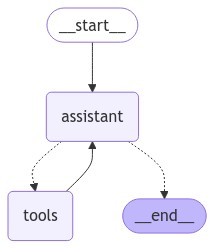

In [42]:
# Visualize the graph
from IPython.display import Image, display

try:
    display(Image(part1_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    print(e)

In [43]:
#example
import uuid

tutorial_questions = [
    "Hi there, what time is my flight?",
    "Am i allowed to update my flight to something sooner? I want to leave later today.",
    "Update my flight to sometime next week then",
    "The next available option is great",
    "what about lodging and transportation?",
    "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    "OK could you place a reservation for your recommended hotel? It sounds nice.",
    "yes go ahead and book anything that's moderate expense and has availability.",
    "Now for a car, what are my options?",
    "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    "Cool so now what recommendations do you have on excursions?",
    "Are they available while I'm there?",
    "interesting - i like the museums, what options are there? ",
    "OK great pick one and book it for my second day there.",
]

db = update_dates(db)
thread_id = str(uuid.uuid4())
print('thread id = ', thread_id)

config = {
    "configurable": {
        "passenger_id": "3442 587242",
        "thread_id":thread_id
    }
}



thread id =  27d64da9-3531-4ffc-8875-7dc3672baf1d


In [44]:
_printed = set ()
for i, question in enumerate(tutorial_questions):
    events = part1_graph.stream(input = {"messages": ('user', question)}, config = config, stream_mode="values")
    for event in events:
        _print_event(event, _printed)
    
    break
    # if i == 2: break



================================ Human Message =================================

Hi there, what time is my flight?
================================== Ai Message ==================================
Tool Calls:
  fetch_user_flight_info (call_m5ho317g)
 Call ID: call_m5ho317g
  Args:
================================= Tool Message =================================
Name: fetch_user_flight_info

[{"ticket_no": "7240005432906569", "book_ref": "C46E9F", "flight_id": 19250, "flight_no": "LX0112", "departure_airport": "CDG", "arrival_airport": "BSL", "scheduled_departure": "2024-09-26 11:04:11.292177-04:00", "scheduled_arrival": "2024-09-26 12:34:11.292177-04:00", "seat_no": "18E", "fare_conditions": "Economy"}]
================================== Ai Message ==================================

Your flight, LX0112, from CDG to BSL is scheduled to depart at 11:04 AM on September 26th, 2024. The expected arrival time is 12:34 PM on the same day.


# Part 2: Add confirmation

Human in the loop approach

User has to confirm before agent commit any actions

In [45]:
#New State
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages] 
    user_info: str #NOTE: will be populated by graph

In [46]:
class Agent:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable
    
    def __run__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)

            #no tool is called
            # and content is empty
            # or content is list and first content has no text attr
            if not result.tool_calls \
                and not result.content \
                or ( isinstance(result.content, list) and not result.content[0].get('text')):
                messages = state['messages'] + [('user', 'Respond with a real output')]
                state = {**state, "messages": messages}
            else: break
        return {'messages': result}


In [47]:
part2_assistant_runnable = primary_assistant_prompt | llm.bind_tools(part1_tools)

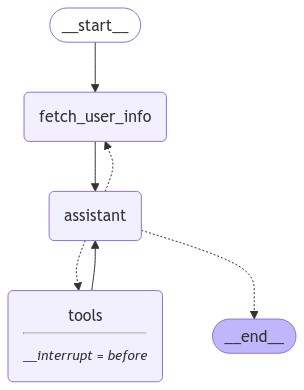

In [48]:
builder = StateGraph(State)

def user_info(state: State):
    return {'user_info': fetch_user_flight_info.invoke({})}

builder.add_node('fetch_user_info', user_info)
builder.add_node('assistant', Assistant(part2_assistant_runnable))
builder.add_node('tools', create_tool_node_with_fallback(part1_tools))

builder.add_edge(START, "fetch_user_info")
builder.add_edge("fetch_user_info", "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition
)

builder.add_edge('tools', 'assistant')

# provide memory to llm
memory = MemorySaver()

part2_graph = builder.compile(
    checkpointer = memory,
    #NOTE: halt graph execution before 'tools' node.
    # user can approve/rejct before assistant continues 
    interrupt_before=['tools'] #user interrupt before using any tools
)


try:
    display(Image(part2_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [49]:
db = update_dates(db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": { 
        "passenger_id" : '3442 587242',
        'thread_id' : thread_id
    }
}

_printed = set()

for question in tutorial_questions:

    events = part2_graph.stream({'messages': ('user', question)}, config, stream_mode = 'values')

    for event in events:
        _print_event(event, _printed)
    
    snapshot = part2_graph.get_state(config)

    while snapshot.next:
        #NOTE: we have an interrupt
        user_input = input(
            "Do you approve of the above actions? type 'y' to continue;"
            " otherwise, explain it"
        )

        if user_input.strip() == 'y': 
            #user said yes
            result = part2_graph.invoke(None, config) # continue graph execution
        else:
            #User provided some explaination why they said no
            result = part2_graph.invoke(
                {"messages": 
                 [ToolMessage(
                    tool_call_id=event['messages'][-1].tool_calls[0]['id'], 
                    content=f"User denied action, reason: {user_input}. Continue asissting, remember uer's input"
                    )]
                },config
            )
        
        snapshot = part2_graph.get_state(config)

    break

================================ Human Message =================================

Hi there, what time is my flight?
================================== Ai Message ==================================
Tool Calls:
  fetch_user_flight_info (call_4tvkd1c6)
 Call ID: call_4tvkd1c6
  Args:


# Part 3 Conditional interrupt

- for read-only tools, llm can query without asking

- for write tools, llm has to ask users to confirm actions

- have route node connecting to assistant, this route node returns if a certain tool is safe (Read more  in tutorial)

# Part 4

A master LLM use sub-graph to direct user's request to a more specialized agent that handle some specific domains